In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,  KFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
import sys 
from sklearn.preprocessing import minmax_scale, MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix 
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier
from xgboost import XGBClassifier
from scipy import spatial
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier


# Special Functions

In [9]:
def smote(X, n = 100):
    """ N, nfeatures = X.shape"""
    XX = np.array(X)
    N, nfeatures = XX.shape
    Xismote = np.zeros([n, nfeatures ])
    np.random.seed(0)
    for k in range(n):
        i = np.random.randint(0,N,1)
        xi  = XX[i]
        XXi = XX #[np.random.randint(0,N,N//4)]
        d = XXi-xi
        d = (d**2).sum(axis = 1)
        dm = d[d>0].min()
        ismote = np.argwhere(d==dm)[0]
        xin = XXi[ismote]
        u = np.random.rand()
        xis = xi + u*( xin - xi)
        Xismote[k,:] = xis
    return Xismote


def cross_val_method(X,y, model , nsplit = 5):
    """ cross validation with precision recall score"""
    cv = KFold(nsplit, random_state=0)
    X = np.array(X)
    y = np.array(y)
    scoring_ = np.zeros(nsplit)
    i_ = 0
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        yh =  model.predict_proba(X_test)[:,1] 
        prec, rec, t = precision_recall_curve(y_test,yh)
        scoring_[i_] = auc(rec,prec)
        i_ = i_ + 1
    return scoring_
        #print(roc_auc_score(y_test, yh) )

def cross_val_method_SMOTE(X,y, model , nsplit = 5, nn = 100):
    cv = KFold(nsplit, random_state=0)
    X = np.array(X)
    y = np.array(y)
    scoring_ = np.zeros(nsplit)
    i_ = 0
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        Xs = smote(X_train[y_train==1],n = nn)
        ys = np.ones(nnn )
        ys =  np.append(y_train , ys ) # y1_train.append(pd.Series(ys))
        Xs =  np.append(X_train, Xs, axis = 0) # X1_train.append(pd.DataFrame(Xs, columns = col_train) ) 
        model.fit(Xs, ys)
        yh =  model.predict_proba(X_test)[:,1] # model.decision_function(X1_test)
        #y_pred = model.predict(X_test)
        prec, rec, t = precision_recall_curve(y_test,yh)
        scoring_[i_] = auc(rec,prec)
        i_ = i_ + 1
    return scoring_

def plot_score_C(SC, C, PLOT = 'SEMILOGX'):
    """ N, C.size = SC.shape"""
    SC = np.array(SC)
    CM =SC.mean(axis =1)
    C_min = SC.min(axis =1)
    C_max = SC.max(axis = 1)
    if PLOT == 'SEMILOGX':
        plt.semilogx(C,CM)
        plt.fill_between(C,C_min, C_max, alpha = 0.4)
    else :
        plt.plot(C,CM)
        plt.fill_between(C,C_min, C_max, alpha = 0.4)
    return


# Reading dataset


In [11]:
df = pd.read_csv('creditcard.csv')
X = df[df.columns[1:-1]]
y = df[df.columns[-1]]

# Scalling the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)



# Resampling with SMOTE Method


In [7]:
nnn = 1000
Xs = smote(X_train[y_train==1],n = nnn)
ys = np.ones(nnn )
ys =  np.append(y_train , ys ) # y1_train.append(pd.Series(ys))
Xs =  np.append(X_train, Xs, axis = 0) # X1_train.append(pd.DataFrame(Xs, columns = col_train) ) 

# Hyperparameter Optimization 

# Logistic Regression

In [13]:
#with SMOTE
nnn = 1000
CC = np.logspace(-1,3, 5)
AUC_C = []
for C in CC:
    model = LogisticRegression(C = C, max_iter = 400, penalty = 'l2',   solver = 'newton-cg') 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    


[0.73194954 0.77075856 0.82797988 0.74510748] , MEAN =  0.7689488636227229 , STD =  0.03682830836324226
[0.72229198 0.76771641 0.82427715 0.74434109] , MEAN =  0.764656657789784 , STD =  0.037985038812036555
[0.71818834 0.76731271 0.82330984 0.74463735] , MEAN =  0.7633620626278443 , STD =  0.038731846581144716
[0.71775913 0.7673129  0.8233222  0.7446354 ] , MEAN =  0.7632574090160498 , STD =  0.03886225239843061
[0.71772929 0.76731288 0.82332212 0.74463536] , MEAN =  0.7632499136834676 , STD =  0.03887096252854592


In [14]:
#without SMOTE
CC = np.logspace(-1,3, 5)
AUC_C_ = []
for C in CC:
    model = LogisticRegression(C = C, max_iter = 400, penalty = 'l2',   solver = 'newton-cg') 
    auc_cros = cross_val_method(X,y, model , nsplit = 4)
    AUC_C_.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    

[0.73502179 0.74017117 0.77099555 0.71629419] , MEAN =  0.7406206770502821 , STD =  0.01965934954408528
[0.73844743 0.73600457 0.75480634 0.71614064] , MEAN =  0.7363497437804019 , STD =  0.013725645766229944
[0.72682566 0.73500703 0.75284106 0.71564254] , MEAN =  0.7325790708972786 , STD =  0.01356826364073209
[0.72531328 0.73490388 0.75275654 0.71562663] , MEAN =  0.7321500815348294 , STD =  0.01371108894708216
[0.72516037 0.73490466 0.75274557 0.71562648] , MEAN =  0.7321092695313213 , STD =  0.013726258277500071


# Plotting of Score of Logistic Regression

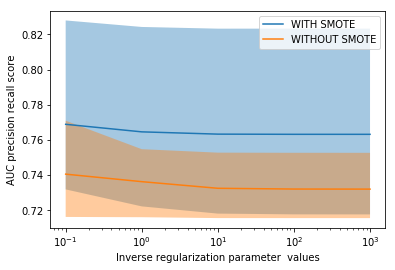

In [15]:
plot_score_C(AUC_C, CC, PLOT = 'SEMILOGX')
plot_score_C(AUC_C_, CC, PLOT = 'SEMILOGX')
plt.xlabel('Inverse regularization parameter  values')
plt.ylabel('AUC precision recall score')
plt.legend(['WITH SMOTE', 'WITHOUT SMOTE'])

# Gradient boosting

In [24]:
#with SMOTE
nnn = 500
CC = np.arange(3,9)
AUC_C = []
for C in CC:
    model = XGBClassifier(  max_depth = C, learning_rate = .2, n_estimators = 100, n_jobs=6 , base_score =  .1) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    


[0.75596538 0.83070185 0.817419   0.77029585] , MEAN =  0.7935955193845325 , STD =  0.031238357563402153
[0.79456646 0.82412076 0.82907992 0.77815542] , MEAN =  0.8064806386449062 , STD =  0.021012894903787094
[0.73141714 0.8211173  0.83765393 0.78234717] , MEAN =  0.7931338857971109 , STD =  0.04089748019768162
[0.78441631 0.81315904 0.83735086 0.79850898] , MEAN =  0.8083587949032102 , STD =  0.019582156588149238
[0.79620521 0.81952576 0.84115453 0.79820134] , MEAN =  0.8137717087516372 , STD =  0.0182616161894758
[0.78844794 0.82455464 0.8352628  0.79550572] , MEAN =  0.8109427740569503 , STD =  0.019500430337600395


In [17]:
AUC_C_ = [np.array([0.74193754, 0.82844531, 0.83576805, 0.78747072]),
 np.array([0.80747834, 0.82296686, 0.83014032, 0.77646171]),
 np.array([0.71383146, 0.82306366, 0.82676935, 0.78195842]),
 np.array([0.76820683, 0.82758158, 0.82634623, 0.78220785]),
 np.array([0.77237748, 0.81517817, 0.84154929, 0.78034926]),
 np.array([0.73885009, 0.8135222 , 0.83389431, 0.78172137])]


In [43]:
#without SMOTE
CC = np.arange(3,9)
AUC_C_ = []
for C in CC:
    model = XGBClassifier(  max_depth = C, learning_rate = .2, n_estimators = 100, n_jobs=4 , base_score =  .1) 
    auc_cros = cross_val_method(X,y, model , nsplit = 4)
    AUC_C_.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    

[0.74193754 0.82844531 0.83576805 0.78747072] , MEAN =  0.7984054065834532 , STD =  0.03743844907861948
[0.80747834 0.82296686 0.83014032 0.77646171] , MEAN =  0.8092618094506567 , STD =  0.020632304520638425
[0.71383146 0.82306366 0.82676935 0.78195842] , MEAN =  0.7864057222903409 , STD =  0.045441798227782756
[0.76820683 0.82758158 0.82634623 0.78220785] , MEAN =  0.8010856248783308 , STD =  0.026351089358853667
[0.77237748 0.81517817 0.84154929 0.78034926] , MEAN =  0.8023635478690991 , STD =  0.027764769600230214


# Plotting Score of Gradient boosting

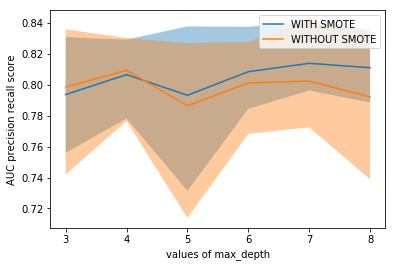

In [25]:
plot_score_C(AUC_C, CC, PLOT = 'o')
plot_score_C(AUC_C_, CC, PLOT = 'o')
plt.xlabel('values of max_depth')
plt.ylabel('AUC precision recall score')
plt.legend(['WITH SMOTE', 'WITHOUT SMOTE'])

The best performance is with max_depth = 7 and using SMOTE Method


# Tuning learning rate 

In [27]:
nnn = 500
CC = np.logspace( np.log10(0.05),  np.log10(0.9), 6)
AUC_C = []
for C in CC:
    model = XGBClassifier(  max_depth = 7, learning_rate = C, n_estimators = 100, n_jobs=6 , base_score =  .1) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )

[0.66086209 0.82367608 0.81739901 0.78559702] , MEAN =  0.7718835512220693 , STD =  0.06570378204474354
[0.67643268 0.81883007 0.83050778 0.79474828] , MEAN =  0.7801297021471656 , STD =  0.06124223346965352
[0.79627743 0.81952996 0.83700407 0.79987581] , MEAN =  0.8131718173752106 , STD =  0.01636006249136045
[0.73289328 0.8219228  0.83410637 0.79421469] , MEAN =  0.7957842845459305 , STD =  0.03908179269370378
[0.74607094 0.81445252 0.84724969 0.78297918] , MEAN =  0.7976880830231698 , STD =  0.037476928708786196
[0.77836162 0.64702471 0.82915417 0.72263666] , MEAN =  0.7442942890293675 , STD =  0.06762434153682234


In [32]:
np.logspace( np.log10(0.05),  np.log10(0.9), 6)
#np.logspace( np.log10(0.05),  np.log10(0.9), 8)

array([0.05      , 0.08913012, 0.15888358, 0.28322625, 0.50487982,
       0.9       ])

Text(0, 0.5, 'AUC precision recall score')

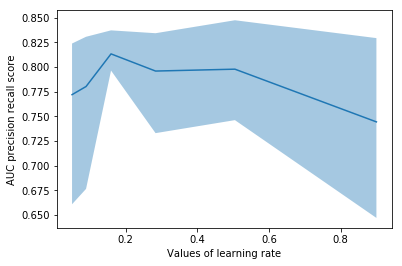

In [28]:
plot_score_C(AUC_C, CC, PLOT = '')
plt.xlabel('Values of learning rate')
plt.ylabel('AUC precision recall score')


The best performance is with learning rate is between 0.16 and 0.2 approximately


# Tuning base score with learning_rate = 0.16

In [35]:
nnn = 500
CC = np.logspace( np.log10(0.05),  np.log10(0.9), 6)
AUC_C = []
for C in CC:
    model = XGBClassifier(  max_depth = 7, learning_rate = 0.16, n_estimators = 100, n_jobs= 6 , base_score =  C) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )

[0.75788773 0.81914589 0.8303415  0.80575652] , MEAN =  0.8032829066588294 , STD =  0.027616309796029956
[0.76512845 0.82062375 0.83392883 0.79782753] , MEAN =  0.8043771429562057 , STD =  0.026079744255163864
[0.74815648 0.81842298 0.83893397 0.80057525] , MEAN =  0.8015221710425271 , STD =  0.03366776636838922
[0.78897899 0.82417139 0.83640427 0.79723156] , MEAN =  0.8116965505036605 , STD =  0.019309431739295082
[0.75068514 0.82144131 0.83163588 0.78919794] , MEAN =  0.7982400677856509 , STD =  0.03161015995242131
[0.7773558  0.81519655 0.82720108 0.78687212] , MEAN =  0.8016563879062542 , STD =  0.02027905349429701


In [37]:
CC


array([0.05      , 0.08913012, 0.15888358, 0.28322625, 0.50487982,
       0.9       ])

Text(0, 0.5, 'AUC precision recall score')

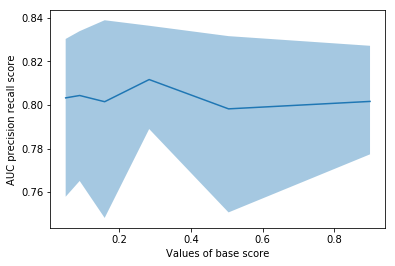

In [36]:
plot_score_C(AUC_C, CC, PLOT = 'o')
plt.xlabel('Values of base score')
plt.ylabel('AUC precision recall score')


The best performance is with learning rate is between 0.25 and 0.3 approximately


In [41]:
NN = (np.logspace( np.log10(10),  np.log10(2000), 8)).astype(int)  
AUC_C = []
for nnn in NN:
    model = XGBClassifier(  max_depth = 7, learning_rate = 0.16, n_estimators = 100, n_jobs= 6, base_score =  0.28) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )

[0.74961022 0.82722558 0.83920531 0.78557769] , MEAN =  0.800404699098589 , STD =  0.03544279617574259
[0.77687942 0.81759297 0.83434234 0.78143603] , MEAN =  0.8025626917844741 , STD =  0.024196184154298243
[0.72781864 0.81775612 0.84357383 0.78455833] , MEAN =  0.7934267292526612 , STD =  0.04327158792832796
[0.73163105 0.81549596 0.83676843 0.79467136] , MEAN =  0.7946417007582657 , STD =  0.03930618143240293
[0.76259266 0.81888681 0.82615482 0.79125987] , MEAN =  0.7997235380328316 , STD =  0.025080766500825812
[0.78341907 0.81771075 0.83979668 0.78907239] , MEAN =  0.8074997242705808 , STD =  0.02273105302045465
[0.71745509 0.82412936 0.84048586 0.79458911] , MEAN =  0.7941648548857185 , STD =  0.04724424598757743
[0.74352009 0.81677074 0.83604063 0.79063314] , MEAN =  0.7967411494439888 , STD =  0.03469662368452702


Text(0, 0.5, 'AUC precision recall score')

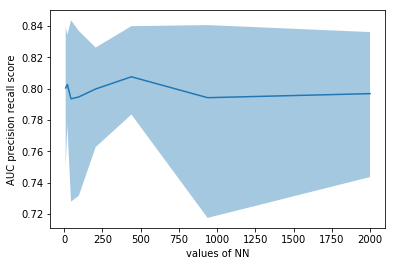

In [42]:
plot_score_C(AUC_C, NN, PLOT = 'o')
plt.xlabel('values of NN')
plt.ylabel('AUC precision recall score')

The best performance is when increasing the number of sampling between 440 and 500